# Part 3, finall version - RNN, LSTM, GRU 

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader

from src import *

## Create dataloader

In [2]:
dataloader = CSVDataLoader('data/MSFT_2006-01-01_to_2018-01-01.csv')
X_train_1, X_test_1 = dataloader.split_by_year([2006, 2007], [2008])

training_dataset_1 = StockTorchDataset(X_train_1, zscore_params=None, history=5)
testing_dataset_1 = StockTorchDataset(X_train_1, zscore_params=training_dataset_1.get_zscore_params(), history=5)

training_loader_1 = DataLoader(training_dataset_1, batch_size=1, shuffle=False, drop_last=False)
testing_loader_1 = DataLoader(testing_dataset_1, batch_size=1, shuffle=False, drop_last=False)

## Train and evaluate models

In [3]:
# Define train function
def train(model: torch.nn.Module,
        dataloader: DataLoader,
        optimizer: torch.optim.Optimizer,
        loss_fn: torch.nn.Module,
        total_epochs: int = 100,
        accum_steps: int = 8,
        test_loader: DataLoader = None,
) -> None:
    model.train()
    optimizer.zero_grad()

    pbar = tqdm(range(total_epochs), desc="Epochs", dynamic_ncols=True, leave=False)
    for epoch in pbar:
        epoch_loss = 0.0
        num_steps = 0.0
        h = None
        for step, (x, y) in enumerate(dataloader):
            x = x.view(x.size(0), 1, -1)
            output, h = model(x, h)
            loss = loss_fn(output, y)
            loss.backward()

            # accumulate loss
            epoch_loss += loss.item()
            num_steps += 1
    
            # update after accum_steps
            if (step + 1) % accum_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            # detach hidden state
            if isinstance(h, tuple):
                h = (h[0].detach(), h[1].detach())
            else:
                h = h.detach()
        
        if (step + 1) % accum_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
    
        # Print epoch loss
        avg_loss = epoch_loss / num_steps
        pbar.set_postfix(loss=f"{avg_loss:.6f}")
    return h
    
# Define evaluate function
@torch.no_grad()
def evaluate(
    model: torch.nn.Module,
    dataloader: DataLoader,
    loss_fn: torch.nn.Module,
) -> None:
    model.eval()
    preds, targets = [], []
    tot_loss = 0.0
    num_steps = 0.0
    h = None

    for x, y in dataloader:
        x = x.view(x.size(0), 1, -1)
        output, h = model(x, h)
        loss = loss_fn(output, y)

        # accumulate loss
        tot_loss += loss.item()
        num_steps += 1

        preds.append(output.item())
        targets.append(y.item())

        # detach hidden state
        if isinstance(h, tuple):
            h = (h[0].detach(), h[1].detach())
        else:
            h = h.detach()
        
    # Print eval loss
    avg_loss = tot_loss / num_steps
    tqdm.write(f"Evaluate mode: loss = {avg_loss:.6f}")
    return preds, targets

In [4]:
# Train RNN on first 2 years, test on 3rd year
years = np.arange(2006, 2018)
train_years = [years[4], years[5]]
test_year = [years[6]]

# Prepare data
history_length = 15

X_train, X_test = dataloader.split_by_year(train_years, test_year)
train_dataset = StockTorchDataset(X_train, zscore_params=None, history=history_length)
test_dataset = StockTorchDataset(X_test, zscore_params=train_dataset.get_zscore_params(), history=history_length)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Model, optimizer, loss
input_size = history_length + 1 + 22  # history + today_change + features
hidden_size = 32
num_layers = 2
rnn_type = "customLSTM" # Choose one from: "RNN", "LSTM", "GRU", "cutomLSTM"
model = FinallModel(input_size=input_size, hidden_size=hidden_size, rnn_type=rnn_type, num_layers=num_layers)
# model = SimpleLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.L1Loss()

# Train model
h = train(model=model, dataloader=train_loader, optimizer=optimizer, loss_fn=criterion, total_epochs=40, accum_steps=8, test_loader=test_loader)

# Evaluate model
preds, targets = evaluate(model=model, dataloader=test_loader, loss_fn=criterion)

Evaluate mode: loss = 0.894860


In [5]:
# Results with/without dropout=0.2, LSTM
# without Evaluate mode: loss = 0.928293
# with Evaluate mode: loss = 0.898524


# Results for different history_length
# 0 - Evaluate mode: loss = 0.792307
# 1 - Evaluate mode: loss = 0.819751
# 2 - Evaluate mode: loss = 0.848286
# 3 - Evaluate mode: loss = 0.851655
# 4 - Evaluate mode: loss = 0.875273
# 5 - Evaluate mode: loss = 0.924159
# 6 - Evaluate mode: loss = 0.940199
# 7 - Evaluate mode: loss = 0.991592
# 8 - Evaluate mode: loss = 0.980053
# 9 - Evaluate mode: loss = 1.092255
# 10 - Evaluate mode: loss = 1.048559
# 11 - Evaluate mode: loss = 1.010351
# 12 - Evaluate mode: loss = 0.887197
# 13 - Evaluate mode: loss = 0.941856
# 14 - Evaluate mode: loss = 0.992764
# 15 -Evaluate mode: loss = 0.962830

## Vizualization

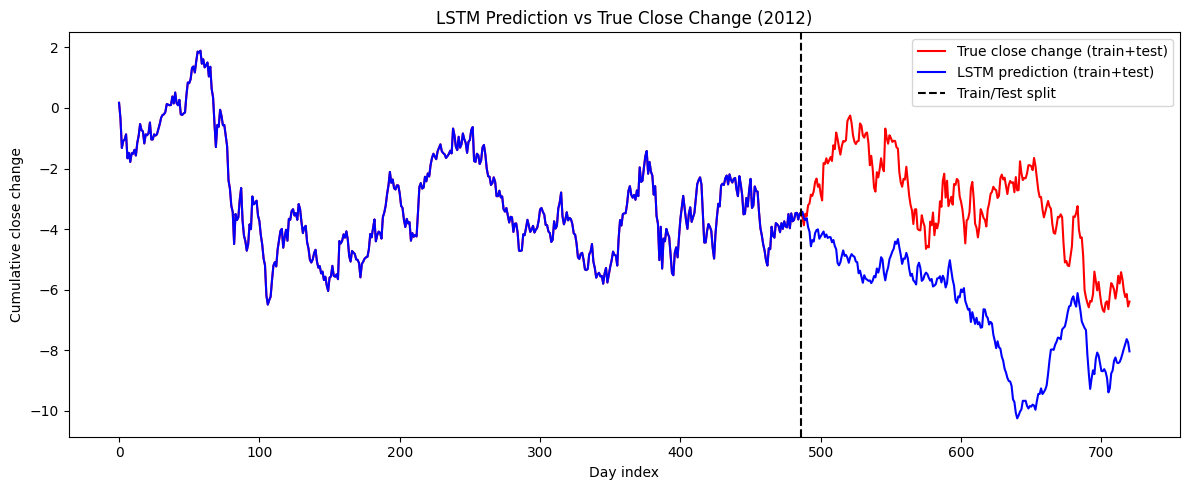

In [6]:
mu, sigma = train_dataset.get_zscore_params()
preds_inv = np.array(preds) * sigma + mu
train_targets = []
for _, y in DataLoader(train_dataset, batch_size=1, shuffle=False):
    train_targets.append(y.item())
train_targets = np.array(train_targets)
train_targets_inv = train_targets * sigma + mu

full_pred = np.concatenate([train_targets_inv, preds_inv])
full_true = np.concatenate([train_targets_inv, np.array(targets) * sigma + mu])

full_pred_curve = np.cumsum(full_pred)
full_true_curve = np.cumsum(full_true)

plt.figure(figsize=(12,5))
plt.plot(full_true_curve, c="r", label="True close change (train+test)")
plt.plot(full_pred_curve, c="b", label="LSTM prediction (train+test)")
plt.axvline(len(train_targets_inv)-1, color='k', linestyle='--', label='Train/Test split')
plt.title(f"LSTM Prediction vs True Close Change ({test_year[0]})")
plt.xlabel("Day index")
plt.ylabel("Cumulative close change")
plt.legend()
plt.tight_layout()
plt.show()